# Properties of finite-energy GKP states

In this notebook we present the functions used for finding and analayzing impefect GKP states in "Towards practical qubit computation using approximate error-correcting grid states" (I. Tzitrin, J. E. Bourassa, N. C. Menicucci, K. K Sabapathy; arXiv:1910.03673). For more details on the implementations here, please see the paper, particularly App. C. 

In Section 2 of this notebook we set up useful functions; in Section 3 we generate two classes of normalizable GKP states; in Section 4 we use the modular subsystem decomposition to plot the location of the qubit associated with imperfect GKP states; in Section 5 we find approximations to GKP states, and in Section 6 we calculate several properties of these approximate states.

# Set-up

## Relevant libraries

In [1]:
# Math, numerics, and graphing
import numpy as np
import scipy as sp
import scipy.integrate as integrate
from scipy.optimize import minimize, basinhopping, fmin_powell
from scipy.special import eval_hermite
from scipy.special import factorial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

# For viewing data
import pandas as pd

## Unit conversions

These functions are from converting between $r$, the real parameter of the squeezing gate, and $\Delta$, the parameter associated with the quality of normalizable GKP states, as well as for going to and from dBs.

In [1]:
def r_to_dB(r):
    '''Converts the squeezing parameter r into dB.'''
    return -10*np.log10(np.exp(-2*r))


def dB_to_D(dB):
    '''Converts the squeezing parameter dB into Delta.'''
    return 1.0/np.sqrt(10**(dB/10.0))


def D_to_r(D):
    '''Converts the squeezing parameter Delta into r.'''
    return -np.log(D)


def dB_to_r(dB):
    '''Converts the squeezing parameter dB into r.'''
    return D_to_r(dB_to_D(dB))


def r_to_D(r):
    '''Converts the squeezing parameter r into Delta.'''
    return dB_to_D(r_to_dB(r))


def D_to_dB(D):
    '''Converts the squeezing parameter Delta into dB.'''
    return r_to_dB(D_to_r(D))

## General quantum functions

In [9]:
def overlap(psi1, psi2, q):
    '''Returns the overlap between two position wavefunctions
    
    Args:
        psi1 (array): the first wavefunction
        psi2 (array): the second wavefunction
        q (array): position values
        
    Returns:
        overlap (float): mod squared inner product of wavefunctions.
    '''
    overlap = np.absolute(integrate.trapz(np.conj(psi1)*psi2,q))**2
    return overlap


def inner_q(psi1, psi2, q):
    '''Returns the inner product between two wavefunctions
    in q space.'''
    return integrate.trapz(np.conj(psi1)*psi2,q)


def num_state(n, q):
    '''Returns the Fock position wavefunctions defined over q space.
    
    Args:
        n (int): Fock index
        q (array): position values
    
    Returns:
        fock (array): nth Fock state wavefunction
    '''
    #Employs the scipy.special eval_hermite function
    fock = ((1/np.sqrt((2**n)*factorial(n)))*(np.pi**-0.25)
            *np.exp(-(q**2)/2)*eval_hermite(n,q)
           )
    return fock


def sq_num_state(r, n, q):
    '''Returns the squeezed Fock position wavefunctions in q space.
    
    Args:
        r (float): squeezing parameter (in r units)
        n (int): Fock index
        q (array): position values
    
    Returns:
        sq_fock (array): squeezed nth Fock state wavefunction
    '''
    sq_fock = np.exp(r/2.0)*num_state(n, q*np.exp(r))
    return sq_fock


def bloch_vec(rho):
    ''' Returns the Bloch vector for a qubit density matrix.
    
    Args:
        rho (array): single qubit density matrix
    
    Returns:
        bloch (array): 4 Stokes parameters; last three components 
            are the Bloch vector
            '''
    vec = rho.flatten('F')
    bloch = np.zeros(4)
    bloch[0] = vec.dot(np.array([1,0,0,1]))
    bloch[1] = vec.dot(np.array([0,1,1,0]))
    bloch[2] = vec.dot(np.array([0,-1.0j,1.0j,0]))
    bloch[3] = vec.dot(np.array([1,0,0,-1]))
    return bloch


def partT(rho2):
    '''Returns partial transpose of two qubit density matrix.'''
    rho2TA = np.zeros(np.shape(rho2))
    for i1 in range(2):
        for j1 in range(2):
            for i2 in range(2):
                for j2 in range(2):
                    rho2TA[2*i1+i2,2*j1+j2] = rho2[2*j1+i2,2*i1+j2]
    return rho2TA


def negativity(rho2):
    '''Returns negativity of a two-qubit density matrix.'''
    eigvals,_ = np.linalg.eig(partT(rho2))
    neg = 0
    for eigval in eigvals:
        if eigval<0:
            neg+=abs(eigval)
    return neg

# Normalizable GKP states

In this section we define the $\Delta$ and $\epsilon$ classes of normalizable GKP states.

## Normalizable GKP states $\left| \psi_\Delta \right>$

The $\Delta = \kappa$ GKP state from Eq. (8) - (11) is defined as $\psi_\Delta(q)=\frac{N_\psi}{(\pi\Delta^2)^{1/4}}\sum_{\mu=0}^{1}c_\mu\sum_{s=-\infty}^{\infty}e^{-\pi\Delta^2[(2s+\mu)]^2/2}e^{-[q-(2s+\mu)\sqrt{\pi}]^2/2\Delta^2}$.


In [10]:
def discrete_q(Nq, qmax):
    '''Returns a discretization of q space.

    Args:
        qmax (float): limits for the q space [-qmax,qmax]
        Nq (float): number of q points in the array 
            (rounds down if not integer)

    Returns:
        q (array): Nq evenly spaced position values from [-qmax, qmax]. 
    '''
    q = np.linspace(-qmax, qmax, Nq)
    return q


def gkp_s_values(smax):
    '''Returns an array of indices to perform the summation over s
    for the superposition of squeezed states in a GKP state.

    Args:
        smax (int): limit for the summation [-smax,smax]

    Returns:
        s (array): integer indices for the summation [-smax,smax].
    '''
    smax = np.ceil(smax)
    s = np.arange(-smax, smax+1, 1)
    return s


def gkp(D, mu=0, sd=7, N=200):
    '''Returns a discretized q space and a normalized logical (0 or 1) 
    GKP state. Default is to return logical 0 (mu=0).

    Args:
        D (float): width of the Gaussian envelope and squeezed states 
            in the superposition
        mu (0 or 1): logical value for the GKP state
        sd (float): number of standard deviations for q space
        N (int): number of points per peak in the GKP comb

    Returns:
        q (array): position values
        gkp (array): array of GKP wavefunction values.
    '''

    # Setting the total range for position space
    qmax = max(sd/D, sd*D)

    # Initiating indices to sum over the comb peaks in each state.
    smax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    s = gkp_s_values(smax)

    # Getting a discretization of position space
    Nq = N*(2*smax+1)
    q = discrete_q(Nq, qmax)

    # Initiating empty arrays to be filled in
    gkp = np.zeros(len(q))

    # Looping over all peaks in the superposition
    for i in range(len(s)):
        gkp = gkp + np.exp(-((D**2)*np.pi*(2*s[i]+mu)**2)/2.0) *\
            np.exp(-((q-(2*s[i]+mu)*np.sqrt(np.pi))**2) /
                   (2*D**2))/(np.pi*D**2)**0.25

    # Normalization constants
    # GKP gives a good approximation of sqrt(2*Delta) if Delta/alpha is small,
    # but we can find them numerically to get a better approximation
    Norm = 1/np.sqrt(integrate.trapz(np.absolute(gkp)**2, q))

    # Normalizing
    gkp = Norm*gkp

    return q, gkp


def any_gkp(D, qubit=[1, 0], sd=7, N=200):
    '''Returns a discretized q space and a superposition of logical 
    normalized GKP states. Default is to return logical 0.

    Args:
        D (float): width of the Gaussian envelope and squeezed states 
            in the superposition
        qubit (array): qubit state in logical basis
        sd (float): number of standard deviations to take for q space
        N (int): number of points per peak in the GKP comb

    Returns:
        q (array): position values
        gkp (array): array of GKP wavefunction values.
    '''

    qubit = qubit/np.linalg.norm(qubit)

    # Setting the total range for position space
    qmax = max(sd/D, sd*D)

    # Initiating indices to sum over the comb peaks in each state.
    smax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    s = gkp_s_values(smax)

    # Getting a discretization of position space
    Nq = N*(2*smax+1)
    q = discrete_q(Nq, qmax)

    # Initiating empty arrays to be filled in
    gkp = np.zeros(len(q))

    # Looping over all peaks in the superposition
    for i in range(len(s)):
        gkp = gkp + qubit[0]*np.exp(-((D**2)*np.pi*(2*s[i])**2)/2.0) *\
            np.exp(-((q-(2*s[i])*np.sqrt(np.pi))**2)/(2*D**2))/(np.pi*D**2)**0.25\
                  + qubit[1]*np.exp(-((D**2)*np.pi*(2*s[i]+1)**2)/2.0) *\
            np.exp(-((q-(2*s[i]+1)*np.sqrt(np.pi))**2) /
                   (2*D**2))/(np.pi*D**2)**0.25

    # Normalization constants
    # GKP gives a good approximation of sqrt(2*Delta) if Delta/alpha is small,
    # but we can find them numerically to get a better approximation
    Norm = 1/np.sqrt(integrate.trapz(np.absolute(gkp)**2, q))

    # Normalizing
    gkp = Norm*gkp

    return q, gkp


def gkp_q(q0, D, mu=0):
    '''Returns a normalized logical GKP state evaluated at a single point in q.
    Default is to return logical mu=0.

    Args:
        q0 (float): value at which to evaluate the GKP wavefunction
        D (float): width of the Gaussian envelope and squeezed states in
            the superposition
        mu (0 or 1): logical value for the gkp state

    Returns:
        gkp_q (float): GKP wavefunction evaluated at q0.
    '''

    # Setting the total range for position space
    qmax = max(3/D**2, 3*D**2)

    # Initiating indices to sum over the comb peaks in each state.
    smax = np.ceil(qmax/np.sqrt(np.pi))
    s = gkp_s_values(smax)

    # Getting a discretization of position space
    Nq = 100*(2*smax+1)
    q = discrete_q(Nq, qmax)

    # Initiating empty arrays to be filled in
    gkp = np.zeros(len(q))
    gkp_q = 0

    # Looping over all peaks in the superposition
    for i in range(len(s)):
        gkp = gkp + np.exp(-((D**2)*np.pi*(2*s[i]+mu)**2)/2.0) *\
            np.exp(-((q-(2*s[i]+mu)*np.sqrt(np.pi))**2) /
                   (2*D**2))/(np.pi*D**2)**0.25
        gkp_q = gkp_q + np.exp(-((D**2)*np.pi*(2*s[i]+mu)**2)/2.0) *\
            np.exp(-((q0-(2*s[i]+mu)*np.sqrt(np.pi))**2) /
                   (2*D**2))/(np.pi*D**2)**0.25
    # Normalization constants
    # GKP gives a good approximation of sqrt(2*Delta) if Delta/alpha is small,
    # but we can find them numerically to get a better approximation
    Norm = 1/np.sqrt(integrate.trapz(np.absolute(gkp)**2, q))

    # Normalizing
    gkp = Norm*gkp
    gkp_q = Norm*gkp_q

    return gkp_q


def gkp_overlap(D):
    '''Returns overlap between normalized logical GKP states for given 
    Delta.

    Args:
        D (float): Normalized GKP parameter

    Returns:
        overlap (float): mod squared of the integal between 
            GKP_0 and conj(GKP_1).
    '''
    # Creating wavefunctions and q space
    q, psi0 = gkp(D)
    _, psi1 = gkp(D, mu=1)
    # Integrating product of wavefunctions to get overlap
    overlap = np.absolute(integrate.trapz(psi0*psi1, q))**2
    return overlap

## Normalizable GKP states $\left| \psi_\epsilon \right>$

The state $\left| \psi_\epsilon \right>$ is defined in Eq. (12) as $\left| \psi_\epsilon \right> = e^{-\epsilon \hat{n}}\left| \psi_I \right>$, where $\left| \psi_I \right>$ is an ideal GKP state.

In [11]:
def gkp_fock_coeff(n, combs=100, alpha=np.sqrt(np.pi), mu=0):
    '''Returns the nth Fock coefficient for the ideal logical GKP state.

    Args:
        n (int): index of Fock state
        combs (int): number of delta spikes in the ideal state used to 
                        calculate inner product with Fock state
        alpha (float): GKP lattice constant
        mu (0 or 1): logical value of GKP state

    Returns:
        coeff (complex): inner product between ideal GKP and nth 
            Fock states.
    '''
    # q values from which to sample the nth Fock state
    samples = (mu+np.arange(-combs/2, 1+combs/2)*2)*alpha
    # sum of sampled values to yield inner product
    coeff = np.sum(num_state(n, samples))
    return coeff


def gkp_fock(qubit, eps, q, n_max=120, norm=True):
    '''Returns the epsilon GKP q wavefunction and coefficients in the 
        Fock basis.

    Args:
        qubit (array): qubit state in logical basis
        eps (float): value of epsilon
        q (array): array of q values for q wavefunction
        n_max (int): Fock cutoff
        norm (Boolean): whether to return a normalized state

    Returns:
        gkp (array): q wavefunction
        coeffs (array): Fock coefficients up to cutoff.
    '''
    qubit = qubit/np.linalg.norm(qubit)
    gkp = 0
    coeffs = np.zeros(n_max+1, dtype=complex)
    # initialize normalization constant
    N = 0
    for i in range(n_max+1):
        # calculate nth coefficient and weight it with an epsilon dependent exponential
        coeff = (qubit[0]*gkp_fock_coeff(i, mu=0)+qubit[1]
                 * gkp_fock_coeff(i, mu=1))*np.exp(-i*eps)
        coeffs[i] = coeff
        gkp += coeff*num_state(i, q)
        if norm:
            N += np.absolute(coeff)**2
    if norm:
        gkp = gkp/np.sqrt(N)
        coeffs = coeffs/np.sqrt(N)
    return gkp, coeffs

# Modular subsystem decomposition

In this section we extract the logical content of GKP states with the help of the modular subsystem decomposition (Sec. IIC; see also arXiv:1907.08210).

## Single qubit states

In [12]:
def subsys_decomp(qubit, eps, N=2**8, sd=5, norm=False, gate=None, apps=0):
    '''Returns the 0 and 1 gauge mode wavefunctions of epsilon GKP 
    states after different single qubit gate applications.

    Args:
        qubit (array) - qubit state in logical basis
        eps (float) - value of epsilon
        N (int) - number of points for q wavefunction
        sd (int) - number of standard deviations in q space
        norm (Boolean) - whether to return a normalized state
        gate (str) - single qubit gate to apply; 
            options: None, H, phase, Z, X
        apps (int) - number of applications of that gate

    Returns:
        qg (array) - array of gauge mode position values
        gkp0 (array) - gauge mode wavefunction for the 0 bins
        gkp1 (array) - gauge mode wavefunction for the 1 bins.
    '''
    qubit = qubit/np.linalg.norm(qubit)

    # Define q values for the centre bin
    q_init = np.linspace(-np.sqrt(np.pi)/2, np.sqrt(np.pi)/2, N)
    # 0 bins q space array
    q0 = np.array([])
    # gauge mode q space array
    qg = np.array([])

    # Filling in the q0 and qg arrays
    qmax = max(sd/np.sqrt(eps), sd*np.sqrt(eps))
    smax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    s = gkp_s_values(smax)
    for i in range(len(s)):
        q0 = np.append(q0, q_init+(2*s[i])*np.sqrt(np.pi))
        qg = np.append(qg, q_init+(s[i])*np.sqrt(np.pi))
    # 1 bins q space array
    q1 = q0+np.sqrt(np.pi)

    # Initiating empty arrays to be filled in for gauge mode wavefunctions
    gkp0 = np.zeros(len(q0), dtype=complex)
    gkp1 = np.zeros(len(q1), dtype=complex)

    # Wavefunctions over 0 and 1 bins
    # Applying additional modifications depending on the gate
    if gate == None:
        gkp0 = gkp_fock(qubit, eps, q0, norm=norm)[0]
        gkp1 = gkp_fock(qubit, eps, q1, norm=norm)[0]
    if gate == "H":
        #A complex epsilon value is the error channel plus a rotation
        gkp0 = gkp_fock(qubit, eps-1j*np.pi/2, q0, norm=norm)[0]
        gkp1 = gkp_fock(qubit, eps-1j*np.pi/2, q1, norm=norm)[0]
    if gate == "phase":
        # Add a quadratic phase
        gkp0 = gkp_fock(qubit, eps, q0, norm=norm)[0]*np.exp(-apps*0.5j*q0**2)
        gkp1 = gkp_fock(qubit, eps, q1, norm=norm)[0]*np.exp(-apps*0.5j*q1**2)
    if gate == "Z":
        # Add a linear phase
        gkp0 = gkp_fock(qubit, eps, q0, norm=norm)[
            0]*np.exp(-apps*1.0j*q0*np.sqrt(np.pi))
        gkp1 = gkp_fock(qubit, eps, q1, norm=norm)[
            0]*np.exp(-apps*1.0j*q1*np.sqrt(np.pi))
    if gate == "X":
        if apps % 2 == 0:
            # Even number of applications doesn't change the wavefunction
            gkp0 = gkp_fock(qubit, eps, q0, norm=norm)[0]
            gkp1 = gkp_fock(qubit, eps, q1, norm=norm)[0]
        if apps % 2 == 1:
            # Odd number applies a bit flip
            gkp1 = gkp_fock(qubit, eps, q0, norm=norm)[0]
            gkp0 = gkp_fock(qubit, eps, q1, norm=norm)[0]
    if norm:
        # Normalize the full wavefunction
        Norm = 1/np.sqrt(integrate.trapz(np.absolute(gkp0)
                                         ** 2+np.absolute(gkp1)**2, qg))
        gkp0 = gkp0*Norm
        gkp1 = gkp1*Norm

    return qg, gkp0, gkp1


def rho_log(qubit, eps, norm=False, gate=None, apps=0):
    '''Returns single qubit logical subsystem density matrix.

    Args:
        qubit (array): qubit state in logical basis
        eps (float): value of epsilon
        norm (Boolean): whether to return a normalized state
        gate (str): single qubit gate to apply; 
            options: None, H, phase, Z, X
        apps (int): number of applications of that gate

    Returns:
        rho (array): logical subsystem qubit density matrix
    '''
    # acquire modular decomposition and integrate out the gauge mode
    qg, gkp0, gkp1 = subsys_decomp(qubit, eps, norm=norm, gate=gate, apps=apps)
    rho_00 = integrate.trapz(np.absolute(gkp0)**2, qg)
    rho_01 = integrate.trapz(gkp0*np.conj(gkp1), qg)
    rho_10 = np.conj(rho_01)
    rho_11 = integrate.trapz(np.absolute(gkp1)**2, qg)
    rho = np.array([[rho_00, rho_01], [rho_10, rho_11]])
    return rho


def bloch_mapping(eps, gate=None, apps=0):
    '''For a given epsilon and gate, returns the corresponding matrix 
        for transforming Bloch vectors; that is, given an ideal GKP 
        qubit state, find how its epsilon form and gates modify the 
        Bloch vector.

    Args:
        eps (float) - value of epsilon
        gate (str) - single qubit gate to apply; 
            options: None, H, phase, Z, X
        apps (int) - number of applications of that gate

    Returns:
        M (array) - 4x4 matrix for transforming Stokes vectors.
    '''
    qubits = np.array(
        [[1, 1]/np.sqrt(2), [1, 1.0j]/np.sqrt(2), [1, 0], [0, 1]])

    rhox = rho_log(qubits[0, :], eps, gate=gate, apps=apps)
    rhoy = rho_log(qubits[1, :], eps, gate=gate, apps=apps)
    rho0 = rho_log(qubits[2, :], eps, gate=gate, apps=apps)
    rho1 = rho_log(qubits[3, :], eps, gate=gate, apps=apps)

    M = np.zeros((4, 4))
    M[:, 0] = bloch_vec((rho0+rho1))
    M[:, 1] = bloch_vec(2*rhox-rho0-rho1)
    M[:, 2] = bloch_vec(2*rhoy-rho0-rho1)
    M[:, 3] = bloch_vec(rho0-rho1)

    return M/2

### Figs. (4) and (11)

c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:53: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:54: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:55: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part


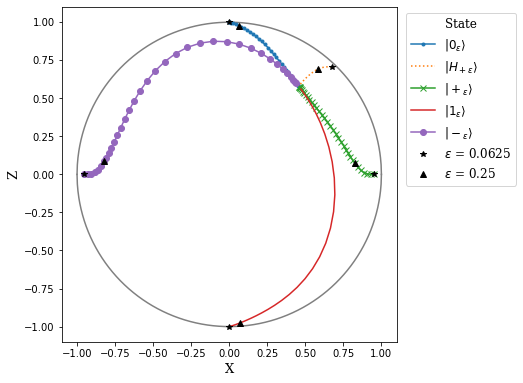

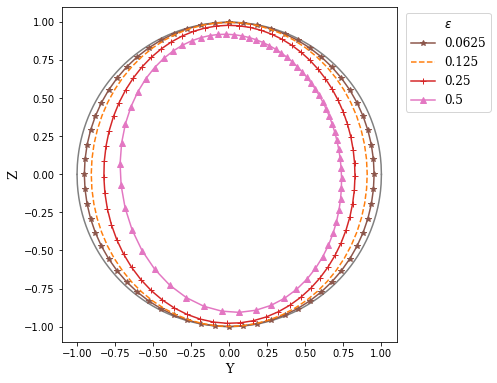

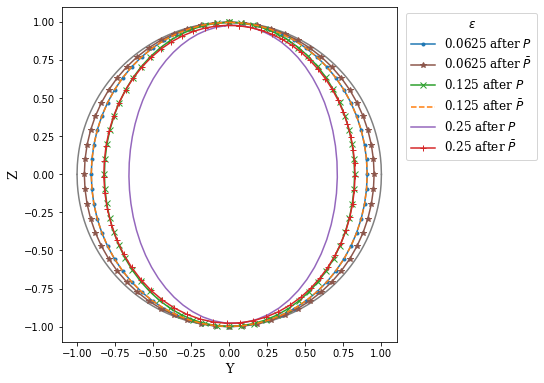

In [7]:
if __name__ == '__main__':
    # FIGURE 4a
    # Initialize qubit
    angles = np.array([0, np.pi/8, np.pi/4, np.pi/2, 3*np.pi/4])
    qubits = np.array([np.cos(angles), np.sin(angles)])
    # Initialize epislon values
    eps_arr = np.append(np.linspace(0.0625, 0.25, 6, endpoint=False),
                        np.logspace(np.log10(0.25), np.log10(3), 30, endpoint=False))
    # Initialize array for Bloch vectors
    vecs = np.zeros((len(eps_arr), len(qubits[0, :]), 3))
    for i in range(len(eps_arr)):
        # Find matrix for mapping ideal to epsilon Stokes vectors
        M = bloch_mapping(eps_arr[i])
        for j in range(len(qubits[0, :])):
            rho = np.outer(qubits[:, j], np.conj(qubits[:, j]))
            # Find Stokes vector before state renormalized (first component =/= 1)
            vec = M.dot(bloch_vec(rho))
            # Renormalize the state
            vec = vec/vec[0]
            # Extract Bloch vector
            vecs[i, j, :] = vec[1:]
    fig = plt.figure()
    fig.set_figheight(8)
    # Draw a circle for the Bloch sphere cross-section
    x = np.linspace(-1, 1, 1000)
    plt.plot(x, np.sqrt(1-x**2), '-', color="gray")
    plt.plot(x, -np.sqrt(1-x**2), '-', color="gray")
    #Linestyles and labels
    styles1 = [".-", ":", "x-", "-", "o-"]
    labels = [r"$|0_\epsilon\rangle$", r"$|{H_+}_\epsilon\rangle$", r"$|+_\epsilon\rangle$",
              r"$|1_\epsilon\rangle$", r"$|-_\epsilon\rangle$"]
    # Loops to plot results
    for j in range(len(angles)):
        # Plotting first and third component of Bloch vector = XZ plane
        plt.plot(vecs[:, j, 0], vecs[:, j, 2], styles1[j], label=labels[j])
        if j == len(angles)-1:
            plt.plot(vecs[0, j, 0], vecs[0, j, 2],
                     'k*', label=r"$\epsilon$ = 0.0625")
            plt.plot(vecs[6, j, 0], vecs[6, j, 2],
                     'k^', label=r"$\epsilon$ = 0.25")
        else:
            plt.plot(vecs[0, j, 0], vecs[0, j, 2], 'k*')
            plt.plot(vecs[6, j, 0], vecs[6, j, 2], 'k^')
    plt.gca().set_aspect('equal', 'box')
    legend = plt.legend(loc='upper left', title="State", bbox_to_anchor=(
        1.01, 1), prop={"size": 12, "family": "serif"})
    plt.setp(legend.get_title(), fontsize=12, family="serif")
    plt.xlabel("X", family="serif", size=13)
    plt.ylabel("Z", family="serif", size=13)
    plt.show()

    # FIGURE 4b
    # Bloch vectors for many angles and few values of epsilon
    angles = np.arange(0, np.pi, np.pi/2**6)
    angles = np.append(angles, angles[0])
    qubits = np.array([np.cos(angles), np.sin(angles)])
    eps_arr = np.array([0.0625, 0.125, 0.25, 0.5])
    vecs = np.zeros((len(eps_arr), len(qubits[0, :]), 3))
    for i in range(len(eps_arr)):
        M = bloch_mapping(eps_arr[i])
        for j in range(len(qubits[0, :])):
            rho = np.outer(qubits[:, j], np.conj(qubits[:, j]))
            vec = M.dot(bloch_vec(rho))
            vec = vec/vec[0]
            vecs[i, j, :] = vec[1:]
    fig = plt.figure()
    fig.set_figheight(8)
    x = np.linspace(-1, 1, 1000)
    plt.plot(x, np.sqrt(1-x**2), '-', color="gray")
    plt.plot(x, -np.sqrt(1-x**2), '-', color="gray")
    styles2 = ["*-", "--", "+-", "^-"]
    colors2 = ['#8c564b', '#ff7f0e', '#d62728', '#e377c2']
    for j in range(len(eps_arr)):
        plt.plot(vecs[j, :, 0], vecs[j, :, 2], styles2[j],
                 color=colors2[j], label=str(eps_arr[j]))
    plt.gca().set_aspect('equal', 'box')
    legend = plt.legend(loc='upper left', title=r"$\epsilon$", bbox_to_anchor=(
        1.01, 1), prop={"size": 12, "family": "serif"})
    plt.setp(legend.get_title(), fontsize=12, family="serif")
    plt.xlabel("Y", family="serif", size=13)
    plt.ylabel("Z", family="serif", size=13)
    plt.show()

    # FIGURE 11
    # Bloch vectors for many angles and few values of epsilon
    angles = np.arange(0, np.pi, np.pi/2**6)
    angles = np.append(angles, angles[0])
    qubits = np.array([np.cos(angles), np.sin(angles)])
    eps_arr = np.array([0.0625, 0.125, 0.25])
    vecs = np.zeros((len(eps_arr), len(qubits[0, :]), 3))
    vecs_ph = np.zeros((len(eps_arr), len(qubits[0, :]), 3))
    vecs_ph2 = np.zeros((len(eps_arr), len(qubits[0, :]), 3))
    Ph = np.array([[1, 0, 0, 0],
                   [0, 0, -1, 0],
                   [0, 1, 0, 0],
                   [0, 0, 0, 1]])
    for i in range(len(eps_arr)):
        M = bloch_mapping(eps_arr[i])
        M_gate = bloch_mapping(eps_arr[i], gate="phase", apps=1)
        for j in range(len(qubits[0, :])):
            rho = np.outer(qubits[:, j], np.conj(qubits[:, j]))
            vec = Ph.dot(M.dot(bloch_vec(rho)))
            vec = vec/vec[0]
            vec2 = bloch_vec(rho)
            vec2 = M_gate.dot(vec2)
            vec2 = vec2/vec2[0]
            vecs[i, j, :] = vec[1:]
            vecs_ph[i, j, :] = vec2[1:]
            #vecs_ph2[i,j,:] = vec3[1:]

    x = np.linspace(-1, 1, 1000)

    fig = plt.figure()
    fig.set_figheight(8)
    plt.plot(x, np.sqrt(1-x**2), '-', color="gray")
    plt.plot(x, -np.sqrt(1-x**2), '-', color="gray")
    styles1 = [".-", "x-", "-", ]
    styles2 = ["*-", "--", "+-"]
    colors1 = ['#1f77b4', '#2ca02c', '#9467bd']
    colors2 = ['#8c564b', '#ff7f0e', '#d62728']
    for j in range(len(eps_arr)):
        plt.plot(vecs_ph[j, :, 1], vecs_ph[j, :, 2], styles1[j],
                 color=colors1[j], label=str(eps_arr[j])+" after $P$")
        plt.plot(vecs[j, :, 1], vecs[j, :, 2], styles2[j],
                 color=colors2[j], label=str(eps_arr[j])+r" after $\bar{P}$")
    plt.gca().set_aspect('equal', 'box')
    legend = plt.legend(loc='upper left', title=r"$\epsilon$", bbox_to_anchor=(
        1.01, 1), prop={"size": 12, "family": "serif"})
    plt.setp(legend.get_title(), fontsize=12, family="serif")
    plt.xlabel("Y", family="serif", size=13)
    plt.ylabel("Z", family="serif", size=13)
    #plt.savefig("Bloch_sphere_ph.pdf", bbox_inches='tight')
    plt.show()

### Single qubit gate fidelities

In [ ]:
def gate_fidelity(eps,gate,qgate,N=2**10):
    thetas, phis = np.linspace(0,np.pi,N,dtype = complex), np.linspace(0,2*np.pi,N,dtype = complex)
    dt = thetas[1]-thetas[0]
    dp = phis[1]-phis[0]
    
    M = bloch_mapping(eps,gate = gate,apps = 1)
    
    avg_gate_fid = 0+0j
    for i in range(N):
        for j in range(N):
            qubit = np.array([np.cos(thetas[i]/2),np.sin(thetas[i]/2)*np.exp(1.0j*phis[j])])
            
            ideal_qubit = qgate@qubit
            ideal_rho = np.outer(ideal_qubit,np.conj(ideal_qubit))
            ideal_bloch = bloch_vec(ideal_rho) 
            
            rho = np.outer(qubit,np.conj(qubit))
            qubit_bloch = bloch_vec(rho)
            vec = M@qubit_bloch
            vec = vec/vec[0]

            gate_fid = 0.5*(1+vec[1:]@ideal_bloch[1:])
            
            avg_gate_fid += gate_fid*np.sin(thetas[i])*dt*dp/(4*np.pi)
    
    return avg_gate_fid


if __name__ == '__main__':    
    eps_vals =4*np.logspace(-2,-1,20)
    I_F = np.zeros(len(eps_vals),dtype = complex)
    H_F = np.zeros(len(eps_vals),dtype = complex)
    X_F = np.zeros(len(eps_vals),dtype = complex)
    Z_F = np.zeros(len(eps_vals),dtype = complex)
    P_F = np.zeros(len(eps_vals),dtype = complex)
    I = np.eye(2,dtype = complex)
    H = (1/np.sqrt(2))*np.array([[1,1],[1,-1]],dtype = complex)
    X = np.array([[0,1],[1,0]],dtype = complex)
    Z = np.array([[1,0],[0,-1]],dtype = complex)
    P = np.array([[1,0],[0,-1j]],dtype = complex)
    
    N = 2**8
    
    for i in range(len(eps_vals)):
        I_F[i] = gate_fidelity(eps_vals[i],None,I,N = N)
        H_F[i] = gate_fidelity(eps_vals[i],"H",H,N = N)
        X_F[i] = gate_fidelity(eps_vals[i],"X",X,N = N)
        Z_F[i] = gate_fidelity(eps_vals[i],"Z",Z,N = N)
        P_F[i] = gate_fidelity(eps_vals[i],"phase",P,N = N)
    
    styles = ['--', 'x-', '-+', '-.', ':', '-']
    plt.plot(eps_vals,I_F, styles[0],label = "I")
    plt.plot(eps_vals,H_F, styles[1],label = "H")
    plt.plot(eps_vals,X_F, styles[2],label = "X")
    plt.plot(eps_vals,Z_F, styles[3],label = "Z")
    plt.plot(eps_vals,P_F, styles[4],label = "P")
    plt.show()

## CNOT gate

In [4]:
def subsys_decomp_2q(qubit1, qubit2, eps, N=300, sd=5, norm=False, gate=None):
    '''Returns the 00, 01, 10 and 11 gauge mode wavefunctions of two 
    qubit epsilon GKP states after different two qubit gate applications.

    Args:
        qubit1 (array): first qubit state in logical basis
        qubit2 (array): second qubit state in logical basis
        eps (float): value of epsilon
        N (int): number of points for q wavefunction
        sd (int): number of standard deviations in q space
        norm (bool): whether to return a normalized state
        gate (str): single qubit gate to apply; options: None, CNOT

    Returns:
        tuple: (qg, [gkp00, gkp01, gkp10, gkp11]), where qg is an array 
            of gauge mode position values and the second element is an
            array of gauge mode wavefunctions for the 00, 01, 10, and 
            11 bins.
    '''
    qubit1 = qubit1/np.linalg.norm(qubit1)
    qubit2 = qubit2/np.linalg.norm(qubit2)

    q_init = np.linspace(-np.sqrt(np.pi)/2, np.sqrt(np.pi)/2, N)
    q0 = np.array([])
    qg = np.array([])

    # Initiating indices to sum over the comb peaks in each state.
    smax = max(int(np.ceil(sd/(2*np.sqrt(eps)*np.sqrt(np.pi)))), 2)
    s = gkp_s_values(smax)
    for i in range(len(s)):
        q0 = np.append(q0, q_init+(2*s[i])*np.sqrt(np.pi))
        qg = np.append(qg, q_init+(s[i])*np.sqrt(np.pi))
    q1 = q0+np.sqrt(np.pi)

    # Initiating empty arrays to be filled in
    gkp0 = np.zeros(len(q0), dtype=complex)
    gkp1 = np.zeros(len(q1), dtype=complex)

    if gate == None:
        gkp00 = np.outer(np.conj(gkp_fock(qubit1, eps, q0, norm=norm)[
                         0]), gkp_fock(qubit2, eps, q0, norm=norm)[0])
        gkp01 = np.outer(np.conj(gkp_fock(qubit1, eps, q0, norm=norm)[
                         0]), gkp_fock(qubit2, eps, q1, norm=norm)[0])
        gkp10 = np.outer(np.conj(gkp_fock(qubit1, eps, q1, norm=norm)[
                         0]), gkp_fock(qubit2, eps, q0, norm=norm)[0])
        gkp11 = np.outer(np.conj(gkp_fock(qubit1, eps, q1, norm=norm)[
                         0]), gkp_fock(qubit2, eps, q1, norm=norm)[0])
    if gate == "CNOT":
        gkp0 = gkp_fock(qubit1, eps, q0, norm=norm)[0]
        gkp1 = gkp_fock(qubit1, eps, q1, norm=norm)[0]
        gkp00 = np.zeros((len(q0), len(q0)))
        gkp01 = np.zeros((len(q0), len(q0)))
        gkp10 = np.zeros((len(q0), len(q0)))
        gkp11 = np.zeros((len(q0), len(q0)))
        for i in range(len(q0)):
            gkp00[:, i] = gkp0[i]*gkp_fock(qubit2, eps, q0+q0[i], norm=norm)[0]
            gkp01[:, i] = gkp0[i]*gkp_fock(qubit2, eps, q1+q0[i], norm=norm)[0]
            gkp10[:, i] = gkp1[i]*gkp_fock(qubit2, eps, q0+q1[i], norm=norm)[0]
            gkp11[:, i] = gkp1[i]*gkp_fock(qubit2, eps, q1+q1[i], norm=norm)[0]
    if norm:
        Norm = 1/np.sqrt(integrate.trapz(integrate.trapz(np.absolute(gkp00)**2+np.absolute(gkp01)**2 +
                                                         np.absolute(gkp10)**2+np.absolute(gkp11)**2, qg), qg))

        # Normalizing
        gkp00 = gkp00*Norm
        gkp01 = gkp01*Norm
        gkp10 = gkp10*Norm
        gkp11 = gkp11*Norm

    return qg, [gkp00, gkp01, gkp10, gkp11]


def rho_2q_log(qubit1, qubit2, eps, norm=False, gate=None):
    '''Returns two qubit logical subsystem density matrix.

    Args:
        qubit1 (array): first qubit state in logical basis
        qubit2 (array): second qubit state in logical basis
        eps (float): value of epsilon
        norm (bool): whether to return a normalized state
        gate (str) - single qubit gate to apply; options: None, CNOT

    Returns:
        array: logical subsystem two qubit density matrix.
    '''
    qg, gkp2q = subsys_decomp_2q(qubit1, qubit2, eps, norm=norm, gate=gate)
    rho2 = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            rho2[i, j] = integrate.trapz(integrate.trapz(
                gkp2q[j]*np.conj(gkp2q[i]), qg), qg)
    return rho2

###  Fig. (13)

In [ ]:
# WARNING: takes a while to compute
if __name__ == '__main__':
    # logical + and 0 states
    qubit1 = [np.cos(np.pi/4), np.sin(np.pi/4)]
    qubit2 = [np.cos(0), np.sin(0)]

    N = 20
    # epsilon values
    e_vals = np.linspace(0.05, 0.5, N)
    neg_vals = np.zeros(N)
    td_vals = np.zeros(N)
    for i in range(len(e_vals)):
        # calculate 2 qubit state
        rho2 = rho_2q_log(qubit1, qubit2, e_vals[i], norm=True, gate="CNOT")
        # calculate negativity and trace distance from maximally entangled state
        neg_vals[i] = negativity(rho2)
        td_vals[i] = 0.5*np.linalg.norm(rho2-0.5*np.array(
            [[1, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [1, 0, 0, 1]]), ord='nuc')
    # plotting
    fig, ax = plt.subplots(2, 1, sharex='col')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    ax[1].set_xlabel(r"$\epsilon$", family="serif")
    ax[0].set_ylabel("Negativity", family="serif")
    ax[1].set_ylabel("Trace distance", family="serif")
    ax[0].axhline(0.5, color='k', linestyle='--',
                  label=r"CNOT[$|+_I\rangle|0_I\rangle$]")
    ax[0].plot(e_vals, neg_vals, 'k',
               label=r"CNOT[$|+_\epsilon\rangle|0_\epsilon\rangle$]")
    ax[1].plot(e_vals, td_vals, 'k')
    plt.subplots_adjust(hspace=0.05)
    ax[0].legend()
    #plt.savefig("CNOT_unit_tests.pdf", bbox_inches='tight')
    plt.show()

# Finding approximate GKP states

In this section we find suitable approximations (squeezed truncated Fock superpositions) to the normalizable GKP states, per Sec. IIIB.

## Cost functions

In [13]:
def psi_approx(r, c, q):
    '''Returns a squeezed superposition of even Fock states defined over
    q space.

    Args:
        r (float): squeezing parameter (in r units)
        c (array): vector of even Fock coefficients (unnormalized)
        q (numpy array): position values

    Returns:
        psi (numpy array): wavefunction for squeezed superposition of 
            even Fock states.
    '''

    # Normalize the vector of coefficients
    c = c/np.sqrt(np.dot(np.conj(c), c))

    # Initialize an array for psi
    psi = np.zeros(len(q))
    for i in range(len(c)):
        # Add each even Fock state
        # The squeezing affects a transformation on the number states
        psi += c[i]*np.exp(r/2.0)*num_state(2*i, q*np.exp(r))
    return psi


def any_overlap_opt(params, D, qubit):
    '''Returns the negative of the overlap between the normalizable and
    approximate GKP states. (This is a function we optimize. Because the 
    optimization is a minimization, we make it negative.)

    Args:
        params (array): first is the r value for squeezing; rest are 
            Fock coefficients
        D (float): Normalized GKP parameter
        qubit (array): qubit state in logical basis

    Returns:
        float: negative overlap between normalizable and approximate GKP
            states.
    '''
    # Extract r and c from the params handed to the function
    r = params[0]
    c = params[1:]

    # Create the GKP logical 0
    q, GKP = any_gkp(D, qubit=qubit)

    # Create the approximate GKP logical 0
    approx = psi_approx(r, c, q)

    # Calculate the negative overlap between
    opt = -overlap(approx, GKP, q)

    return opt

## Average photon number functions

In [7]:
def creation(cutoff):
    '''Returns matrix form of creation operator in the Fock basis up to 
    a cutoff.

    Args:
        cutoff (int): Fock dimension cutoff

    Returns:
        numpy array: Fock basis representation of creation operator.
    '''
    a_dagger = np.diag(np.sqrt(np.arange(1, cutoff)), k=-1)
    return a_dagger


def annihilation(cutoff):
    '''Returns matrix form of annihilation operator in the Fock basis up
    to a cutoff.

    Args:
        cutoff (int): Fock dimension cutoff

    Returns:
        numpy array: Fock basis representation of annihilation operator.
    '''
    a = np.transpose(np.conj(creation(cutoff)))
    return a


def squeezed_N(r, cutoff):
    '''Returns matrix form of S†(r) N S(r) in the Fock basis.

    Args:
        r (float): squeezing parameter (in r units)
        cutoff (int): Fock dimension cutoff

    Returns:
        numpy array: Fock basis representation of S†(r) N S(r).
    '''
    # Initialize creation and annihilation operators
    a_dag = creation(cutoff)
    a = annihilation(cutoff)

    # S†(r) N S(r) in terms of r and a's
    squeezed_N = np.dot(a_dag, a)*np.cosh(2*r)+np.identity(cutoff) * \
        np.sinh(r)**2-0.5*np.sinh(2*r)*(np.dot(a_dag, a_dag)+np.dot(a, a))
    return squeezed_N


def navg_gkp_approx(r, c, cutoff=50):
    '''Returns average photon number for squeezed superposition of even 
    Fock states.

    Args:
        r (float): squeezing parameter (in r units)
        c (array): coefficients for even Fock states

    Returns:
        float: average photon number for squeezed superposition of even 
        Fock states.
    '''
    # Initialize a ket for all Fock states
    ket = np.zeros((cutoff), dtype=np.complex128)
    # Fill in even Fock state coefficients
    ket[0:2*len(c):2] = c
    # <ket|S†(r) N S(r)|ket>
    navg = np.dot(np.conj(ket), np.dot(squeezed_N(r, cutoff=cutoff), ket))
    return navg

## Example optimization

basinhopping step 0: f -0.968906
basinhopping step 1: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
found new global minimum on step 1 with function value -0.968906
basinhopping step 2: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
found new global minimum on step 2 with function value -0.968906
basinhopping step 3: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
basinhopping step 4: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
basinhopping step 5: f -0.775534 trial_f -0.775534 accepted 1  lowest_f -0.968906
basinhopping step 6: f -0.775534 trial_f -0.775534 accepted 1  lowest_f -0.968906
basinhopping step 7: f -0.946709 trial_f -0.946709 accepted 1  lowest_f -0.968906
basinhopping step 8: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
found new global minimum on step 8 with function value -0.968906
basinhopping step 9: f -0.968906 trial_f -0.968906 accepted 1  lowest_f -0.968906
found new global minimum on step 9

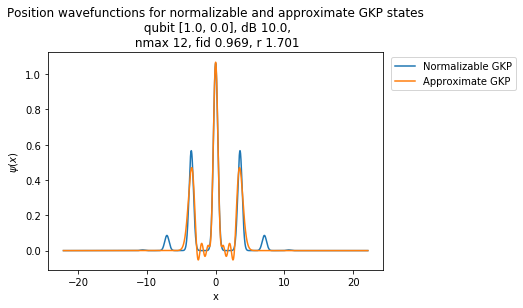

In [11]:
if __name__ == '__main__':
    # Normalized (Target) GKP squeezing in dB
    dB = 10.0
    # Convert to a Delta value
    D = dB_to_D(dB)
    # Logical target state
    qubit = [np.cos(0), np.sin(0)]
    # Convert D, mu into a tuple (required for pass to the minimization function)
    arg = tuple([D, qubit])

    # Search range of squeezing values for the Approximate GKP
    D_max = dB_to_D(-12)  # -12 dB
    D_min = dB_to_D(12)  # 12 dB
    # Maximum number of photons in Approximate GKP. Rounds down to nearest even state.
    n_max = 12

    # The initial minimization guess corresponds to a squeezing, r, followed by coefficients, c.
    # Creating the initial guess, and bounds on the parameters
    x0 = np.array([D_to_r(dB_to_D(0)), np.random.rand()])  # Guess array
    bounds = ((-np.log(D_max), -np.log(D_min)), (-1, 1))  # Array of bounds
    for i in range(int(n_max/2)):  # Filling in the rest of the guess and bound arrays
        x0 = np.append(x0, np.random.rand())
        bounds += ((-1, 1),)
    # Corrected max number of photons after rounding
    n_max = 2*(len(x0[1:])-1)

    # Constraint that vector of coefficients is normalized
    # (speeds up search)
    def norm_constr(x):
        return np.sum(x[1:]**2)-1

    # Minimization
    # Optimization function: any_overlap_opt - negative fidelity between target and approximate
    # Initial guess: x0 - squeezing, r, followed by coefficients, c
    # niter: number of basinhops
    # stepsize: size of hop
    # args: arg - target squeezing, D, and qubit state, qubit
    # method: SLSQP - Sequential Least SQuares Programming
    # bounds: for r - -log(D_max) to -log(D_min); for c's - -1 to 1
    # maxiter and ftol: 1000 and 1e-10, set by trial and error
    # constraints: c has to be normalized
    res = basinhopping(any_overlap_opt, x0, niter=10, stepsize=0.5,
                       minimizer_kwargs={'method': 'SLSQP', 'args': arg, 'bounds': bounds,
                                         'options': {'maxiter': 1e3, 'ftol': 1e-10},
                                         'constraints': {'type': 'eq', 'fun': norm_constr}},
                       disp=True)

    # Minimization result (its negative is fidelity)
    fid = (-res.fun)
    # Parameters that yield the minimum
    r_opt = res.x[0]  # Squeezing
    # Even Fock coefficients
    c_opt = res.x[1:]/np.sqrt(np.dot(res.x[1:], res.x[1:]))
    print(navg_gkp_approx(r_opt, c_opt))

    # Print results
    print("Normalizable GKP squeezing parameter is: r= " +
          str(-np.log(D))+" ("+str(r_to_dB(-np.log(D)))+" dB)")
    print("Photon cutoff for approximate state is: n_max = " +
          str(n_max)+" (only even states)")
    print("Fidelity with approximate state is: "+str(fid))
    print("Optimal squeezing parameter is: r= " +
          str(r_opt)+" ("+str(r_to_dB(r_opt))+" dB)")
    print("Optimal Fock coefficients are: "+str(c_opt))

    q, GKP = any_gkp(D, qubit=qubit)
    psi = psi_approx(r_opt, c_opt, q)
    # Plot position wavefunctions for target state and approximation
    plt.title('Position wavefunctions for normalizable and approximate GKP states\n '
              + 'qubit '+str(qubit)+', dB '+str(dB) +
              ',\n nmax '+str(n_max)+', fid '+str(np.around(fid, 3))+', r '+str(np.around(r_to_dB(r_opt), 3)))
    plt.ylabel(r'$\psi(x)$')
    plt.xlabel('x')
    plt.plot(q, GKP, label="Normalizable GKP")
    plt.plot(q, psi, label="Approximate GKP")
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    #plt.savefig("n"+str(n_max)+"dB"+str(dB)+"r"+str(r_opt)+".pdf", bbox_inches='tight')
    plt.show()

## Parameter space exploration

We can perform the same example as above, looping over:
- $\Delta$ from 0 to 11 dB
- $n_{\max}$ from 0 to 12

For each Approximate GKP state, we find the:
- $\Delta$ value of the target
- optimized fidelity with the target
- parameters (r,c) that yield the optimum
- average photon number of the Approximate

In [24]:
if __name__ == '__main__':
    # target state
    # Logical 0,1,+,magic => angle = 0,1,0.5,0.25
    angle = 1
    qubit = [np.cos(angle*np.pi/2), np.sin(angle*np.pi/2)]
    print(qubit)
    # dB values for parameter space search
    dB_arr = np.around(np.linspace(3, 11, 3), decimals=2)
    # n_max values for parameter space search
    n_arr = np.arange(2, 14, 2)

    # Arrays for storing logical 0 results
    # Optimal fidelity
    f_arr = np.zeros((len(n_arr), len(dB_arr)))
    # Optimal squeezing
    r_arr = np.zeros((len(n_arr), len(dB_arr)))
    # Optimal even Fock coefficients
    c_arr = np.zeros((len(n_arr), len(dB_arr), len(n_arr)+1))
    # Average photon number
    navg_arr = np.zeros((len(n_arr), len(dB_arr)))
    # Photon number spread
    #nsd0_arr = np.zeros((len(n_arr),len(dB_arr)))

    # Search range of squeezing values for the Approximate GKP
    D_max = dB_to_D(-20)  # -14 dB
    D_min = dB_to_D(20)  # 14 dB

    def norm_constr(x):
        return np.sum(x[1:]**2)-1

    # The following repeats, looping over different Delta and n_max values
    for i in range(len(n_arr)):  # Loop over n_max
        n_max = n_arr[i]
        print("\n n_max =", n_max)
        print("\n")

        # Randomize the initial guesses for the basinhopping at the start of a new n_max
        x0 = np.array([np.random.uniform(-np.log(D_max), -
                                         np.log(D_min)), np.random.uniform(-1, 1)])
        bounds = ((-np.log(D_max), -np.log(D_min)), (0, 1))
        for k in range(int(n_max/2)):
            x0 = np.append(x0, np.random.uniform(-1, 1))
            bounds += ((-1, 1),)

        for j in range(len(dB_arr)):  # Loop over Delta

            print("\n dB =", dB_arr[j])
            print("\n")
            D = dB_to_D(dB_arr[j])
            arg = tuple([D, qubit])

            # Basinhopping to optimize fidelity
            res = basinhopping(any_overlap_opt, x0, niter=10, stepsize=3,
                               minimizer_kwargs={'method': 'SLSQP', 'args': arg, 'bounds': bounds,
                                                 'options': {'maxiter': 1e3, 'ftol': 1e-10},
                                                 'constraints': {'type': 'eq', 'fun': norm_constr}},
                               disp=True)

            # Pass results as guesses for next value of Delta
            x0 = res.x

            f_arr[i, j] = -res.fun

            psi = psi_approx(res.x[0], res.x[1:], q)

            r_arr[i, j] = res.x[0]
            c_arr[i, j, :i+2] = res.x[1:]
            navg_arr[i, j] = navg_gkp_approx(r_arr[i, j], c_arr[i, j, :])

    # Saving data
    # Creating multi-indexing based on n_max and Delta values
    index = []
    for i in range(len(n_arr)):
        for j in range(len(dB_arr)):
            index.append((n_arr[i], dB_arr[j]))
    index = pd.MultiIndex.from_tuples(index, names=['n_max', 'Delta (dB)'])

    # Table headers for target state info
    header = np.array(["r (dB)", "c_0", "c_2", "c_4", "c_6",
                       "c_8", "c_10", "c_12", "Navg", "Fidelity"])
    # Putting all the data into a big table
    table = np.c_[np.hstack(r_to_dB(r_arr)), np.vstack(
        c_arr), np.hstack(navg_arr), np.hstack(f_arr)]
    # Converting a data frame
    data = pd.DataFrame(table, index=index, columns=header)

    # Save data as csv so it can be easily imported again
    data.to_csv("Squeezed_fock_table_"+str(angle)+".csv")

    # Open a txt file to write the data tables in a readable format
    file = open("Squeezed_fock_table_"+str(angle)+".txt", "w")
    # Write the table in file
    file.write(data.to_string())
    # Close file
    file.close()

    print("Done")

[6.123233995736766e-17, 1.0]

 n_max = 2



 dB = 3.0


basinhopping step 0: f -0.667798
basinhopping step 1: f -0.667798 trial_f -0.137843 accepted 0  lowest_f -0.667798
basinhopping step 2: f -0.137843 trial_f -0.137843 accepted 1  lowest_f -0.667798
basinhopping step 3: f -0.137843 trial_f -0.137843 accepted 1  lowest_f -0.667798
basinhopping step 4: f -0.986043 trial_f -0.986043 accepted 1  lowest_f -0.986043
found new global minimum on step 4 with function value -0.986043
basinhopping step 5: f -0.702545 trial_f -0.702545 accepted 1  lowest_f -0.986043
basinhopping step 6: f -0.702545 trial_f -0.702545 accepted 1  lowest_f -0.986043
basinhopping step 7: f -0.702545 trial_f -0.702545 accepted 1  lowest_f -0.986043
basinhopping step 8: f -0.986043 trial_f -0.986043 accepted 1  lowest_f -0.986043
found new global minimum on step 8 with function value -0.986043
basinhopping step 9: f -0.986043 trial_f -0.986043 accepted 1  lowest_f -0.986043
basinhopping step 10: f -0.986043 trial_f -

c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part


basinhopping step 1: f -0.870627 trial_f -0.437281 accepted 0  lowest_f -0.870627
basinhopping step 2: f -0.740153 trial_f -0.740153 accepted 1  lowest_f -0.870627
basinhopping step 3: f -0.740153 trial_f -0.740153 accepted 1  lowest_f -0.870627
basinhopping step 4: f -0.870627 trial_f -0.870627 accepted 1  lowest_f -0.870627
found new global minimum on step 4 with function value -0.870627
basinhopping step 5: f -0.870627 trial_f -0.870627 accepted 1  lowest_f -0.870627
basinhopping step 6: f -0.740153 trial_f -0.740153 accepted 1  lowest_f -0.870627
basinhopping step 7: f -0.740153 trial_f -0.740153 accepted 1  lowest_f -0.870627
basinhopping step 8: f -0.0866607 trial_f -0.0866607 accepted 1  lowest_f -0.870627
basinhopping step 9: f -0.0866607 trial_f -0.0866607 accepted 1  lowest_f -0.870627
basinhopping step 10: f -0.740153 trial_f -0.740153 accepted 1  lowest_f -0.870627

 dB = 11.0


basinhopping step 0: f -0.580056
basinhopping step 1: f -0.517703 trial_f -0.517703 accepted 1  

basinhopping step 5: f -0.671643 trial_f -0.290265 accepted 0  lowest_f -0.999997
basinhopping step 6: f -0.671643 trial_f -0.671643 accepted 1  lowest_f -0.999997
basinhopping step 7: f -0.671643 trial_f -0.290265 accepted 0  lowest_f -0.999997
basinhopping step 8: f -0.999997 trial_f -0.999997 accepted 1  lowest_f -0.999997
found new global minimum on step 8 with function value -0.999997
basinhopping step 9: f -0.994497 trial_f -0.994497 accepted 1  lowest_f -0.999997
basinhopping step 10: f -0.671643 trial_f -0.671643 accepted 1  lowest_f -0.999997

 dB = 7.0


basinhopping step 0: f -0.992831
basinhopping step 1: f -0.985989 trial_f -0.985989 accepted 1  lowest_f -0.992831
basinhopping step 2: f -0.988136 trial_f -0.988136 accepted 1  lowest_f -0.992831
basinhopping step 3: f -0.985989 trial_f -0.985989 accepted 1  lowest_f -0.992831
basinhopping step 4: f -0.993209 trial_f -0.993209 accepted 1  lowest_f -0.993209
found new global minimum on step 4 with function value -0.993209
bas

## Loading back saved data

In [22]:
def get_data_pt(filename, n_max, Delta):
    '''Returns a parameter data point for the approximate GKP states.

    Args:
        gkp_data (pandas dataframe): data object where point will be 
            coming from
        n_max (even int): maximum number of photons in superposition 
            (even valued)
        Delta (float): desired value of Delta in dB
        mu (0 or 1): logical value of qubit

    Returns:
        tuple: squeezing for approximate state and array of even Fock 
            coefficients.
    '''
    gkp_data = pd.read_csv(filename, index_col=[0, 1])
    # First check if Delta value is available, and if not, set to nearest
    Delta_vals = gkp_data.index.levels[1].values
    if Delta not in Delta_vals:
        print("Data point not available for Delta =", Delta)
        Delta = Delta_vals[np.argmin(abs(Delta-Delta_vals))]
        print("Setting Delta to", Delta)
    # Return r and c as numpy objects
    r = D_to_r(dB_to_D(gkp_data.loc[n_max, Delta]['r (dB)']))
    c = gkp_data.loc[n_max, Delta]['c_0':'c_'+str(n_max)].values
    return r, c


if __name__ == '__main__':
    filename = r'Squeezed_fock_table_0.csv'
    r, c = get_data_pt(filename, 12, 11)
    print(r, c)

0.20167672056709754 [ 0.60888833 -0.33553385  0.25689409 -0.05961404  0.39282765  0.33139497
  0.42777032]


# Properties of approximate GKP states

In this section we investigate approximate GKP states under various metrics.

## Fidelity - Fig. (19)

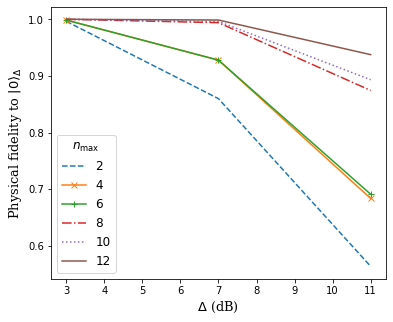

In [13]:
if __name__ == '__main__':
    # Uses the data generated from Parameter space exploration if angle = 0
    fig, ax = plt.subplots(1, 1, sharex='col')
    fig.set_figheight(5)
    styles = ['--', 'x-', '-+', '-.', ':', '-']
    for i in range(2, 14, 2):
        ax.plot(dB_arr, f_arr[int(i/2)-1, :],
                styles[int(i/2 - 1)], label=str(i))
    ax.set_ylabel(r"Physical fidelity to $|0\rangle_\Delta$",
                  family="serif", size=13)
    ax.set_xlabel(r"$\Delta$ (dB)", family="serif", size=13)
    plt.subplots_adjust(hspace=0)
    # ,loc='center', bbox_to_anchor= (0.5, -0.3),ncol = 3)
    legend = ax.legend(title=r"$n_{\max}$", prop={'size': 12})
    plt.setp(legend.get_title(), fontsize=12)
    #plt.savefig("Fidelities0.pdf",bbox_inches = "tight")
    plt.show()

## Average photon number - Fig. (20)

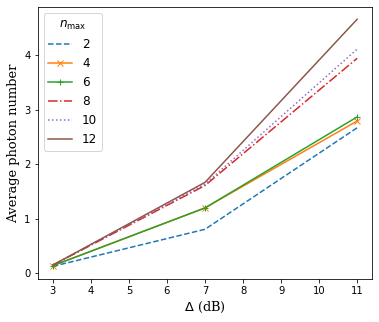

In [14]:
if __name__ == '__main__':
    # Uses the data generated from Parameter space exploration if angle = 0
    styles = ['--', 'x-', '-+', '-.', ':', '-']
    fig, ax = plt.subplots(1, 1, sharex='col')
    fig.set_figheight(5)
    for i in range(2, 14, 2):
        ax.plot(dB_arr, navg_arr[int(i/2)-1, :],
                styles[int(i/2 - 1)], label=str(i))
    ax.set_ylabel(r"Average photon number", family="serif", size=13)
    ax.set_xlabel(r"$\Delta$ (dB)", family="serif", size=13)
    plt.subplots_adjust(hspace=0)
    # ,loc='center', bbox_to_anchor= (0.5, -0.3),ncol = 3)
    legend = ax.legend(title=r"$n_{\max}$", prop={'size': 12})
    plt.setp(legend.get_title(), fontsize=12)
    #plt.savefig("Photons0.pdf",bbox_inches = "tight")
    plt.show()

## Glancy-Knill property - Fig. (22)

c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:147: ComplexWarning: Casting complex values to real discards the imaginary part


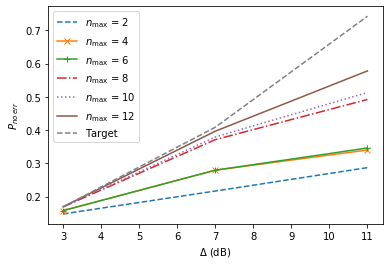

In [15]:
def disp_gkp(disp, D, mu=0, sd=7, N=100):
    '''Returns a discretized q space and a normalized GKP state
    displaced by disp. 
    
    Default is to return logical 0 (mu=0).

    Args:
        disp (complex): value of displacement
        D (float): width of the Gaussian envelope and squeezed states in 
            the superposition.
        mu (0 or 1): logical value for the GKP state
        sd (float): number of standard deviations to take for the q space
        N (int): number of points per peak in the GKP comb

    Returns:
        tuple: array of position values and array of GKP wavefunction 
            values.
    '''

    # Extract q and p displacement values
    q_disp = np.real(disp)
    p_disp = np.imag(disp)

    # Setting the total range for position space
    qmax = max(sd/D, sd*D)

    # Initiating indices to sum over the comb peaks in each state.
    smax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    s = gkp_s_values(smax)

    # Getting a discretization of position space
    Nq = N*(2*smax+1)
    q = discrete_q(Nq, qmax)

    # Initiating empty arrays to be filled in
    gkp = np.zeros(len(q))
    gkp_norm = np.zeros(len(q))

    # Looping over all peaks in the superposition
    # Note the extra terms due to the displacements
    for i in range(len(s)):
        gkp = gkp + np.exp(1.0j*q*p_disp)*np.exp(-((D**2)*np.pi*(2*s[i]+mu)**2)/2.0)\
            * np.exp(-((q+q_disp-(2*s[i]+mu)*np.sqrt(np.pi))**2)/(2*D**2))/(np.pi*D**2)**0.25
        gkp_norm = gkp_norm + np.exp(-((D**2)*np.pi*(2*s[i]+mu)**2)/2.0)\
            * np.exp(-((q-(2*s[i]+mu)*np.sqrt(np.pi))**2)/(2*D**2))/(np.pi*D**2)**0.25

    # Normalization constants
    # GKP gives a good approximation of sqrt(2*Delta) if Delta/alpha is small,
    # but we can find them numerically to get a better approximation
    N = 1/np.sqrt(integrate.trapz(np.absolute(gkp_norm)**2, q))

    # Normalizing
    gkp = N*gkp

    return q, gkp


def intervals(q, threshold, alpha=2*np.sqrt(np.pi), mu=0):
    '''Returns bins in q space for the Glancy Knill condition 
    integration.
    
    Assumes q array is finely enough discretized that there are values 
    in it close to the analytic value of the bin border (multiples 
    of alpha).

    Args:
        q (array): discretized q space points
        threshold (float): value for Glancy-Knill condition is 
            sqrt(pi)/6.
        alpha (float): spacing of GKP ideal comb peaks
        mu (0 or 1): logical value for GKP

    Returns:
        array: nearest to ideal points for integration in q array.
    '''
    # defines the edges of the positive bins
    intervals = np.append(
        np.arange(0, q[-1], alpha)+threshold, np.arange(0, q[-1], alpha)-threshold)
    # sorts them in ascending order
    intervals = np.sort(intervals)
    # populates the negative bin values
    intervals = np.append(-np.flip(intervals[2:]), intervals)+mu*np.sqrt(np.pi)
    # finds nearest point in the predefined array of q space points
    fitted_intervals = np.searchsorted(q[1:-2], intervals)
    return fitted_intervals


def glancy_knill_gkp(D, threshold=np.sqrt(np.pi)/6, alpha=2*np.sqrt(np.pi), mu=0, N=1e4, sd=5):
    '''Calculates the Glancy Knill condition for normalizable GKP states 
    using Eq. (B33).

    Args:
        D (float): Delta value for normalizable GKP states
        threshold (float): value for Glancy Knill condition, 
            default is sqrt(pi)/6.
        alpha (float): spacing of ideal GKP comb peaks
        mu (0 or 1): logical value of GKP
        N (int): number of points in q space per comb. More means lower error in integration.
        sd (int): number of standard deviations to take in Gaussian envelope

    Returns:
        float: probability of no error according to 
            Glancy-Knill condition.
    '''
    q, psi = gkp(D, N=N, sd=sd, mu=mu)

    qmax = max(q)
    tmax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    tvals = np.arange(-tmax, tmax)

    # Finds intervals for integration
    intvals = intervals(q, threshold, alpha=alpha, mu=mu)
    # Loop over t and intervals to calculate Eq. (B33)
    p_no_error = 0
    for i in range(len(tvals)):
        _, gkpt = disp_gkp(-2*np.sqrt(np.pi)*tvals[i], D, N=N, sd=sd, mu=mu)
        for j in range(int(len(intvals)/2)):
            l = intvals[2*j]
            u = intvals[2*j+1]
            p = integrate.trapz(np.conj(gkpt[l:u])*psi[l:u], x=q[l:u])
            p_no_error += p*np.sinc(tvals[i]/3)/3
    return p_no_error


def glancy_knill_approx_gkp(D, r, c, threshold=np.sqrt(np.pi)/6, alpha=2*np.sqrt(np.pi), mu=0, N=1e4, sd=5):
    '''Calculates the Glancy Knill condition for approximate GKP states using Eq. (B33).

    Args:
        D (float): Delta value for normalizable GKP states
        r (float): squeezing value for approximate state
        c (numpy array): coefficients for even Fock elements of approximate state
        threshold (float): value for Glancy Knill condition, default = sqrt(pi)/6
        alpha (float): spacing of ideal GKP comb peaks
        mu (0 or 1): logical value of GKP
        N (int): number of points in q space. More means lower error in integration.
        sd (int): number of standard deviations to take in Gaussian envelope

    Returns:
        float: probability of no error according to Glancy Knill condition
    '''
    q, gkp0 = gkp(D, N=N, sd=sd, mu=mu)
    psi = psi_approx(r, c, q)

    qmax = max(q)
    tmax = int(np.ceil(qmax/(2*np.sqrt(np.pi))))
    tvals = np.arange(-tmax, tmax)

    intvals = intervals(q, threshold, alpha=alpha, mu=mu)
    p_no_error = 0
    for i in range(len(tvals)):
        psi_disp = psi_approx(r, c, q+tvals[i]*2*np.sqrt(np.pi))
        for j in range(int(len(intvals)/2)):
            l = intvals[2*j]
            u = intvals[2*j+1]
            p = integrate.trapz(np.conj(psi_disp[l:u])*psi[l:u], x=q[l:u])
            p_no_error += p*np.sinc(tvals[i]/3)/3
    return p_no_error


if __name__ == '__main__':
    # Uses the data generated from Parameter space exploration if angle = 0
    gkp0_GK = np.zeros(len(dB_arr))
    approx0_GK = np.zeros((6, len(dB_arr)))

    for i in range(2, 14, 2):
        for j in range(len(dB_arr)):
            if i == 2:
                gkp0_GK[j] = glancy_knill_gkp(dB_to_D(dB_arr[j]), mu=0)
            r0, c0 = r_arr[int(i/2)-1, j], c_arr[int(i/2)-1, j, :]
            approx0_GK[int(
                i/2-1), j] = glancy_knill_approx_gkp(dB_to_D(dB_arr[j]), r0, c0)

    fig.set_figheight(3.6)
    fig.set_figwidth(4.9)
    styles = ['--', 'x-', '-+', '-.', ':', '-']
    for i in range(2, 14, 2):
        plt.plot(dB_arr, approx0_GK[int(i/2-1), :],
                 styles[int(i/2 - 1)], label=r"$n_{\max}$ = "+str(i))
    plt.plot(dB_arr, gkp0_GK, '--', color="gray", label="Target")
    plt.ylabel(r"$P_{no\; err}$")
    plt.xlabel(r"$\Delta$ (dB)")
    plt.legend()
    #plt.savefig("GlancyKnill0.pdf",bbox_inches = "tight")
    plt.show()

## Logical subsystem Bloch sphere - Fig. (24)

In [14]:
def subsys_decomp_approx(D, r, c, N=2**8, sd=5):
    '''Returns the 0 and 1 gauge mode wavefunctions of approximate GKP states 
    after different single qubit gate applications.

    Args:
        D (float): Delta value that approximate GKP is targetting
        r (float): squeezing parameter (in r units)
        c (array): vector of even Fock coefficients
        N (int): number of points for q wavefunction
        sd (int): number of standard deviations in q space

    Returns:
        tuple: array of gauge mode position values; gauge mode 
        wavefunction for the 0 bins (array); gauge mode wavefunction for 
        the 1 bins (array).
    '''
    q_init = np.linspace(-np.sqrt(np.pi)/2, np.sqrt(np.pi)/2, N)
    q0 = np.array([])
    qg = np.array([])

    # Populating arrays of 0 and 1 bins in q space
    smax = max(int(np.ceil(sd/(2*D*np.sqrt(np.pi)))), 5)
    s = gkp_s_values(smax)
    for i in range(len(s)):
        q0 = np.append(q0, q_init+(2*s[i])*np.sqrt(np.pi))
        qg = np.append(qg, q_init+(s[i])*np.sqrt(np.pi))
    q1 = q0+np.sqrt(np.pi)

    # Evaluating the approximate GKP state on the 0 and 1 bins
    gkp0 = psi_approx(r, c, q0)
    gkp1 = psi_approx(r, c, q1)

    return qg, gkp0, gkp1


def rho_log_approx(D, r, c):
    '''Returns single qubit logical subsystem density matrix
    for approximate GKP states.

    Args:
        D (float): Delta value that approximate GKP is targetting
        r (float): squeezing parameter (in r units)
        c (array): vector of even Fock coefficients

    Returns:
        array: logical subsystem qubit density matrix.
    '''
    qg, gkp0, gkp1 = subsys_decomp_approx(dB_to_D(D), r, c)
    rho_00 = integrate.trapz(np.absolute(gkp0)**2, qg)
    rho_01 = integrate.trapz(gkp0*np.conj(gkp1), qg)
    rho_10 = np.conj(rho_01)
    rho_11 = integrate.trapz(np.absolute(gkp1)**2, qg)
    return np.array([[rho_00, rho_01], [rho_10, rho_11]])


if __name__ == '__main__':
    # Uses the data generated from Parameter space exploration if angle = 0
    vecs = np.zeros((len(dB_arr), 6, 3))

    for i in range(2, 14, 2):
        for j in range(len(dB_arr)):
            k = int(i/2 - 1)
            r, c = r_arr[int(i/2)-1, j], c_arr[int(i/2)-1, j, :]
            vec = bloch_vec(rho_log_approx(dB_arr[j], r, c))
            vecs[j, k, :] = vec[1:]

    x = np.linspace(-1, 1, 1000)
    fig, ax = plt.subplots(3, 2, sharex='col', sharey='row')
    for k in range(6):
        i, j = int((k/2)), int(k % 2)
        ax[i, j].set_xlabel("X", size=12, family='serif')
        if j == 0:
            ax[i, j].set_ylabel("Z", size=12, family='serif')
        ax[i, j].plot(x, np.sqrt(1-x**2), color="xkcd:grey")
        ax[i, j].plot(x, -np.sqrt(1-x**2), color="xkcd:grey")
        ax[i, j].plot(vecs[:, k, 0], vecs[:, k, 2], "--", label='0')
        ax[i, j].plot(vecs[0, k, 0], vecs[0, k, 2],
                      'k.', label=r'$\Delta$ = 3 dB')
        ax[i, j].plot(vecs[-1, k, 0], vecs[-1, k, 2],
                      'k*', label=r'$\Delta$ = 11 dB')
        ax[i, j].set_aspect('equal', 'box')
        ax[i, j].text(0, 0, r'$n_{\max}$='+str(2*k+2), horizontalalignment='center',
                      verticalalignment='center', size=14, family='serif')
    ax[2, 0].legend(loc='center', bbox_to_anchor=(
        1, -0.35), ncol=3, prop={'size': 13})
    fig.set_figwidth(6.66)
    fig.set_figheight(10)
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0.02)
    #plt.savefig("Bloch_approx.pdf",bbox_inches = 'tight')
    plt.show()

NameError: name 'dB_arr' is not defined

## Projectors - Fig. (31)

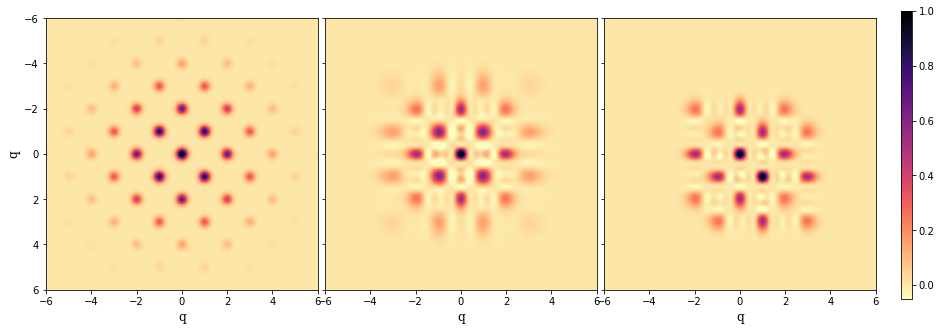

In [31]:
def gkp_proj(D, sd=3, N=100):
    '''Returns the projector for normalizable GKP states

    Args:
        D (float): Delta normalization parameter for GKP state
        sd (int): number of stadard deviations in Gaussian envelope
        N (int): number of points in q space per comb. More means lower 
            error in integration.

    Returns:
        tuple: discretized q space for projector (array) and projector 
        for normalized gkp states (array).
    '''
    q, gkp0 = gkp(D, mu=0, sd=sd, N=N)
    _, gkp1 = gkp(D, mu=1, sd=sd, N=N)

    projector = np.outer(gkp0, np.conj(gkp0))+np.outer(gkp1, np.conj(gkp1))
    return q, projector


def approx_gkp_proj(D, r0, c0, r1, c1, sd=3, N=100):
    '''Returns the projector for approximate 0 and 1 GKP states

    Args:
        D (float): Delta normalization parameter for GKP state
        r0 (float): squeezing parameter for logical 0
        c0 (array): even Fock coefficients for logical 0
        r1 (float): squeezing parameter for logical 1
        c1 (array): even Fock coefficients for logical 1
        sd (int): number of stadard deviations in Gaussian envelope
        N (int): number of points in q space per comb. More means lower 
            error in integration.

    Returns:
        tuple: discretized q space for projector (array) and projector 
            for approximate gkp states (array).
    '''
    q, _ = gkp(D, mu=0, sd=sd, N=N)
    psi0 = psi_approx(r0, c0, q)
    psi1 = psi_approx(r1, c1, q)

    projector = np.outer(psi0, np.conj(psi0))+np.outer(psi1, np.conj(psi1))

    return q, projector


def approx_gkp_proj_disp(D, r0, c0, sd=3, N=100):
    '''Returns the projector for approximate 0 and displaced 0 GKP states

    Args:
        D (float) : Delta normalization parameter for GKP state
        r0 (float) : squeezing parameter for logical 0
        c0 (array) : even Fock coefficients for logical 0
        sd (int) : number of stadard deviations in Gaussian envelope
        N (int): number of points in q space per comb. More means lower 
            error in integration.

    Returns:
        tuple: discretized q space for projector (array) and projector 
        for approximate gkp states (array).
    '''
    q, _ = gkp(D, mu=0, sd=sd, N=N)
    psi0 = psi_approx(r0, c0, q)
    # Create logical 1 from displacing 0
    psi1 = psi_approx(r0, c0, q-np.sqrt(np.pi))

    projector = np.outer(psi0, np.conj(psi0))+np.outer(psi1, np.conj(psi1))

    return q, projector


if __name__ == '__main__':
    nmax = 12
    dB = 11
    D = dB_to_D(dB)

    # Retrieve approximate GKP parameters
    r0, c0 = get_data_pt(r"Squeezed_fock_table_0.csv", nmax, dB)
    r1, c1 = get_data_pt(r"Squeezed_fock_table_1.csv", nmax, dB)

    # Normalizable GKP projector
    q, projGKP = gkp_proj(D)

    # Approximate GKP projector
    q, projApprox = approx_gkp_proj(D, r0, c0, r1, c1)
    dq = q[1]-q[0]

    # Approximate displaced GKP projector
    q, projApprox2 = approx_gkp_proj_disp(D, r0, c0)
    dq = q[1]-q[0]

    q = q/np.sqrt(np.pi)
    fig, ax = plt.subplots(1, 3, sharey='row')
    fig.set_figheight(5)
    fig.set_figwidth(15)
    im0 = ax[0].imshow(projGKP,
                       extent=(q[0], q[-1], q[-1], q[0]),
                       cmap='magma_r',
                       interpolation='none',
                       vmin=-0.05,
                       vmax=1)
    ax[0].set_ylabel("q", family='serif', size=12)
    im1 = ax[1].imshow(projApprox,
                       extent=(q[0], q[-1], q[-1], q[0]),
                       cmap='magma_r',
                       interpolation='none',
                       vmin=-0.05,
                       vmax=1)
    im2 = ax[2].imshow(projApprox2, extent=(q[0], q[-1], q[-1], q[0]),
                       cmap='magma_r',
                       interpolation='none',
                       vmin=-0.05,
                       vmax=1)
    ax[0].set_xlabel("q", family='serif', size=12)
    ax[1].set_xlabel("q", family='serif', size=12)
    ax[2].set_xlabel("q", family='serif', size=12)
    fig.colorbar(im2, cax=fig.add_axes([0.92, 0.1, 0.01, 0.8]))
    fig.subplots_adjust(wspace=0)
    #plt.savefig("ProjEg.pdf",bbox_inches = "tight")
    plt.show()

## Quantum Error Correction Matrix - Fig. (32)

c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:106: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:108: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:110: ComplexWarning: Casting complex values to real discards the imaginary part
c:\users\xanadu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:112: ComplexWarning: Casting complex values to real discards the imaginary part


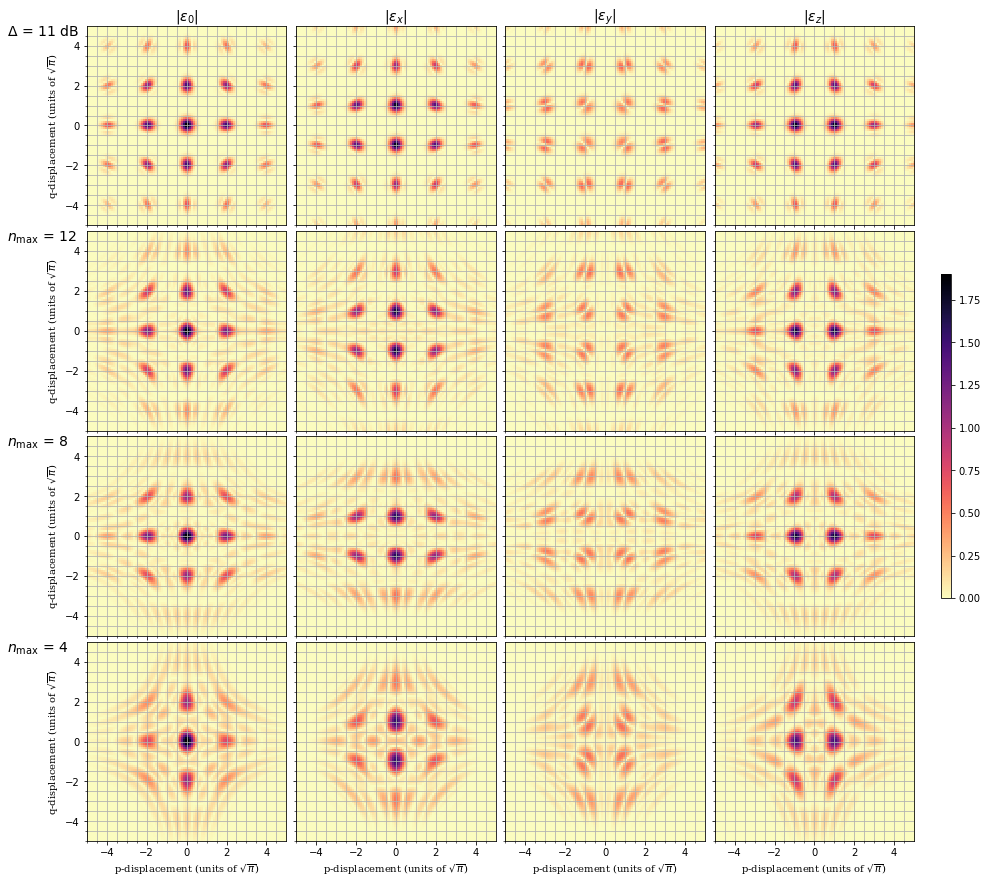

In [32]:
def QEC_disp(D, disp, sd=7, N=200):
    ''' Returns the normalizable state QEC matrix for a displacement 
    error.

    Args:
        D (float): width of the Gaussian envelope and squeezed states 
            in the superposition
        disp (complex): value of displacement operator

    Returns:
        QEC (2d numpy array): QEC matrix for displacement errors.
    '''
    # Generate undisplaced GKP states
    q, gkp0 = gkp(D, mu=0, sd=7, N=200)
    _, gkp1 = gkp(D, mu=1, sd=7, N=200)
    # Generate displaced GKP states
    _, disp0 = disp_gkp(disp, D, mu=0, sd=7, N=200)
    _, disp1 = disp_gkp(disp, D, mu=1, sd=7, N=200)
    # Calculate elements of QEC matrix
    QEC_00 = inner_q(disp0, gkp0, q)
    QEC_01 = inner_q(disp0, gkp1, q)
    QEC_10 = inner_q(disp1, gkp0, q)
    QEC_11 = inner_q(disp1, gkp1, q)

    QEC = np.array([[QEC_00, QEC_01], [QEC_10, QEC_11]])
    return QEC


def QEC_disp_approx(D, r0, c0, r1, c1, disp):
    ''' Returns the approximate state QEC matrix for a displacement 
    error.

    Args:
        D (float): width of the Gaussian envelope and squeezed states 
            in the superposition
        r0 (float): squeezing parameter for logical 0
        c0 (array): even Fock coefficients for logical 0
        r1 (float): squeezing parameter for logical 1
        c1 (array): even Fock coefficients for logical 1
        disp (complex): value of displacement operator

    Returns:
        QEC (2d numpy array): QEC matrix for displacement errors.
    '''
    q_disp = np.real(disp)
    p_disp = np.imag(disp)
    q, _ = gkp(D)
    # Generate undisplaced approximate GKP states
    psi0 = psi_approx(r0, c0, q)
    psi1 = psi_approx(r1, c1, q)
    # Generate displaced approximate GKP states
    disp0 = psi_approx(r0, c0, q-q_disp)*np.exp(1.0j*q*p_disp)
    disp1 = psi_approx(r1, c1, q-q_disp)*np.exp(1.0j*q*p_disp)
    # Calculate elements of QEC mtx
    QEC_00 = inner_q(disp0, psi0, q)
    QEC_01 = inner_q(disp0, psi1, q)
    QEC_10 = inner_q(disp1, psi0, q)
    QEC_11 = inner_q(disp1, psi1, q)

    QEC = np.array([[QEC_00, QEC_01], [QEC_10, QEC_11]])
    return QEC


def pauli_coeffs(mtx):
    '''Returns the coefficients for the Pauli matrix expansion of a 2D
    Hermitian matrix.'''
    identity = [[1, 0], [0, 1]]
    pauli_x = [[0, 1], [1, 0]]
    pauli_y = [[0, -1.0j], [1.0j, 0]]
    pauli_z = [[1, 0], [0, -1]]
    e0 = np.trace(np.dot(identity, mtx))
    ex = np.trace(np.dot(pauli_x, mtx))
    ey = np.trace(np.dot(pauli_y, mtx))
    ez = np.trace(np.dot(pauli_z, mtx))
    return e0, ex, ey, ez


if __name__ == '__main__':
    dB = 11
    D = dB_to_D(dB)
    _, gkp0 = gkp(D, mu=0)
    _, gkp1 = gkp(D, mu=1)

    # Set range of displacement values
    alpha = np.linspace(-5, 5, 100)*np.sqrt(np.pi)
    mina = alpha[0]/np.sqrt(np.pi)
    maxa = alpha[-1]/np.sqrt(np.pi)

    # Arrays for normalizable gkp Pauli coefficients
    I_err = np.zeros((len(alpha), len(alpha)))
    X_err = np.zeros((len(alpha), len(alpha)))
    Y_err = np.zeros((len(alpha), len(alpha)))
    Z_err = np.zeros((len(alpha), len(alpha)))

    # Arrays for approximate gkp Pauli coefficients
    I_err_Ap = np.zeros((len(alpha), len(alpha), 3))
    X_err_Ap = np.zeros((len(alpha), len(alpha), 3))
    Y_err_Ap = np.zeros((len(alpha), len(alpha), 3))
    Z_err_Ap = np.zeros((len(alpha), len(alpha), 3))

    # Loading data for approximate states
    r04, c04 = get_data_pt(r"Squeezed_fock_table_0.csv", 4, dB)
    r14, c14 = get_data_pt(r"Squeezed_fock_table_1.csv", 4, dB)
    r08, c08 = get_data_pt(r"Squeezed_fock_table_0.csv", 8, dB)
    r18, c18 = get_data_pt(r"Squeezed_fock_table_1.csv", 8, dB)
    r012, c012 = get_data_pt(r"Squeezed_fock_table_0.csv", 12, dB)
    r112, c112 = get_data_pt(r"Squeezed_fock_table_1.csv", 12, dB)

    # Calculate QEC matrix Pauli coefficients
    for i in range(len(alpha)):
        for j in range(len(alpha)):
            disp = alpha[i]+1.0j*alpha[j]
            I_err[i, j], X_err[i, j], Y_err[i, j], Z_err[i,
                                                         j] = pauli_coeffs(QEC_disp(D, disp))
            I_err_Ap[i, j, 0], X_err_Ap[i, j, 0], Y_err_Ap[i, j, 0], Z_err_Ap[i, j, 0] = \
                pauli_coeffs(QEC_disp_approx(D, r04, c04, r14, c14, disp))
            I_err_Ap[i, j, 1], X_err_Ap[i, j, 1], Y_err_Ap[i, j, 1], Z_err_Ap[i, j, 1] = \
                pauli_coeffs(QEC_disp_approx(D, r08, c08, r18, c18, disp))
            I_err_Ap[i, j, 2], X_err_Ap[i, j, 2], Y_err_Ap[i, j, 2], Z_err_Ap[i, j, 2] = \
                pauli_coeffs(QEC_disp_approx(D, r012, c012, r112, c112, disp))

    # Plotting data
    fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(15, 15))

    for i, mtx, ax, title in zip(np.arange(16), np.absolute([I_err, X_err, Y_err, Z_err,
                                                             I_err_Ap[:, :, 2], X_err_Ap[:, :,
                                                                                         2], Y_err_Ap[:, :, 2], Z_err_Ap[:, :, 2],
                                                             I_err_Ap[:, :, 1], X_err_Ap[:, :,
                                                                                         1], Y_err_Ap[:, :, 1], Z_err_Ap[:, :, 1],
                                                             I_err_Ap[:, :, 0], X_err_Ap[:, :, 0], Y_err_Ap[:, :, 0], Z_err_Ap[:, :, 0]]), axs.flatten(),
                                 [r'|$\varepsilon_0$|', r'|$\varepsilon_x$|', r'|$\varepsilon_y$|', r'|$\varepsilon_z$|',
                                  r'', r'', r'', r'', r'', r'', r'', r'', r'', r'', r'', r'']):
        im = ax.imshow(mtx, extent=(mina, maxa, mina, maxa),
                       interpolation='none', vmin=0, vmax=1.9, cmap='magma_r')
        if i % 4 == 0:
            if i == 0:
                ax.text(-9, 4.5, r"$\Delta$ = 11 dB", fontsize=14)
            else:
                ax.text(-9, 4.5, r"$n_{\max}$ = "+str(16-i), fontsize=14)
            ax.set_ylabel(
                r"q-displacement (units of $\sqrt{\pi}$)", family='serif')
        if i >= 12:
            ax.set_xlabel(
                r"p-displacement (units of $\sqrt{\pi}$)", family='serif')
        ax.set_title(title, fontsize=14)
        ax.set_xticks(np.arange(mina, maxa, 0.5), minor=True)
        ax.set_yticks(np.arange(mina, maxa, 0.5), minor=True)
        ax.grid(True, which='both')
    fig.subplots_adjust(wspace=0, hspace=0.03)
    plt.colorbar(im, cax=fig.add_axes([0.92, 0.35, 0.01, 0.3]))
    #plt.savefig("QEC.pdf", bbox_inches='tight')
    plt.show()